In [1]:
import numpy as np 
import networkx as nx
from matplotlib import pyplot as plt

In [31]:
# Defining some utilities (early implementation, will be refactored in a class)

def randomEnvironment(n: int,
                      d: int):
    
    return np.random.multivariate_normal(np.zeros(d),
                                         np.eye(d),
                                         n)

def distanceBasedPermutation(x: np.array, 
                             ord = 2):
    
    DBP = np.zeros((x.shape[0],x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            DBP[i,j] = np.linalg.norm(x[i] - x[j], ord)

    return np.argsort(DBP, 1)

def randomizedConstruction(x: np.array,
                           ord = 2,
                           m = None,
                           scheme = 'paper'):

    n = x.shape[0]
    A = np.zeros((n,n))

    DBP = distanceBasedPermutation(x, ord)
    if not m:
        m = int(np.floor(np.sqrt(3 * n * np.log(n))))

    for i in range(n):

        # Deterministic step
        A[i, DBP[i, 1:m]] = 1
        A[DBP[i,1:m], i]
        
        # Randomized step
        if scheme == 'paper':
            S = int(np.ceil(3 * n * np.log(n)/m))
        else:
            S = m
        R = np.random.choice(np.concatenate([np.arange(0,i), np.arange(i+1,n)]), S)

        A[i, R] = 1
        A[R, i] = 1

    return A


In [46]:
X = randomEnvironment(100, 5)

In [47]:
randomizedConstruction(X)

array([[0., 1., 1., ..., 0., 1., 1.],
       [1., 0., 1., ..., 1., 1., 0.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [0., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 0., 1., ..., 1., 1., 0.]])

# Paper construction

Very dense graph with proved bounds on degree for navigability

In [48]:
A = randomizedConstruction(X)
G = nx.from_numpy_matrix(A)

In [49]:
np.mean(list(dict(G.degree()).values()))

74.66

_________

In [38]:
# Greedy routing algorithm

def greedyRouting(s: int,
                  t: int,
                  x: np.array,
                  A: np.array
                  ):
    
    done = False
    j = s

    steps = 0

    while not done:
        
        if np.all(A[j] == 0):
            done = True
            print(j)

        else:
            neighs = np.where(A[j] == 1)[0]
            X_ = np.copy(x[neighs])
            h = neighs[np.argmin(np.linalg.norm(X_ - x[t], axis = 1))]

            if np.linalg.norm(x[t] - x[h]) < np.linalg.norm(x[t] - x[j]):
                j = h
                steps += 1
                
            else:
                done = True


    return x[j], A, steps

In [39]:
X = randomEnvironment(1000, 5)
A = randomizedConstruction(X)

X1, B, steps = greedyRouting(0, 50, X, A)

In [40]:
np.all(X1 == X[50])

True

In [41]:
steps

1

Paper baseline is ok, now let's try to work out something sharper with a sparser graph. 

________

In [50]:
N = X.shape[0]

In [51]:
Ms = np.arange(1,np.sqrt(3 * N * np.log(N)))

In [52]:
Ms

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37.])

In [53]:
A = randomizedConstruction(X, 2, 2, 'other')
G = nx.from_numpy_matrix(A)
nx.is_connected(G)

True

In [54]:
np.mean(list(dict(G.degree()).values()))

5.4

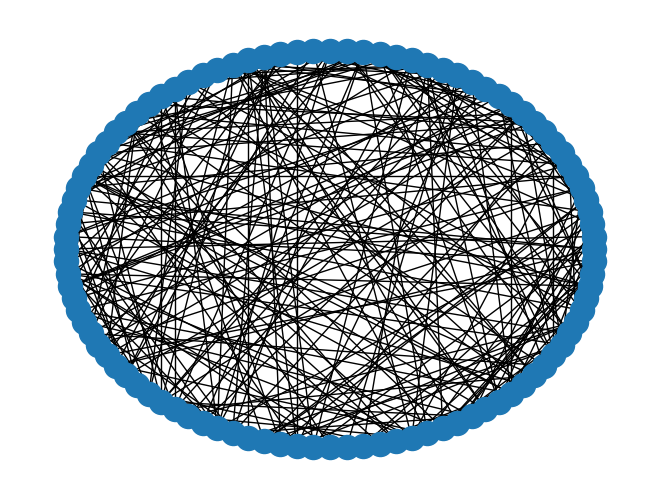

In [55]:
nx.draw_circular(G)